In [4]:
import numpy as np
import tensorflow as tf
import pandas as pd
import time as time
import matplotlib.pyplot as plt
%matplotlib inline
print("TensorFlow version:",tf.__version__)

TensorFlow version: 1.0.0


In [5]:
data_dir ="/tmp/RC_filter/data/"
model_dir ="/tmp/RC_filter/"
summaries_dir = "/tmp/RC_filter/logs/1/"

In [6]:
#Extract data from CSV
df1=pd.read_csv(data_dir+"RC_filter_classify.csv")
col1 = df1[['R1','C1','R2','C2']]
col2 = df1[['LP','HP','BP','NA']]
col3 = df1[['fL','fH']]
#Convert to Numpy array
InputX1 = col1.as_matrix()
InputY1 = col2.as_matrix()
plotX = col3.as_matrix()
InputX1.astype(float, copy=False);
InputY1.astype(float, copy=False);
plotX.astype(float, copy=False);
#print("Input:",InputX1)
#print("Output:",InputY1)

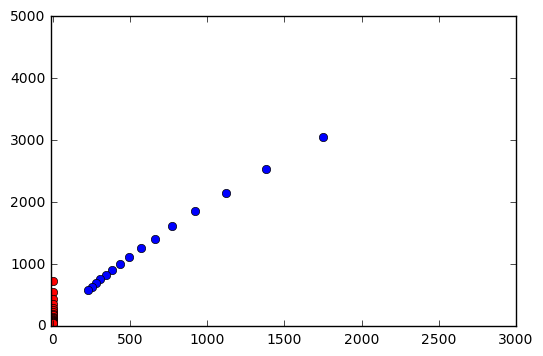

In [8]:
plt.plot(plotX[1:26,0:1],plotX[1:26,1:2], 'ro')  #Low Pass filter
plt.plot(plotX[59:74,0:1],plotX[59:74,1:2], 'bo') #Band Pass filter
plt.axis([-1e1, 3e3, -1e1, 5e3])
plt.show()

In [11]:
#Data Preprocessing
X1_min = np.amin(InputX1,0)     #Find minimum and maximum
X1_max = np.amax(InputX1,0)   
print("Mininum values:",X1_min)  
print("Maximum values:",X1_max)
Y1_min = np.amin(InputY1)     
Y1_max = np.amax(InputY1) 
InputX1_norm = (InputX1-X1_min)/(X1_max-X1_min)  #Min-max Normalization on input data
InputY1_norm = InputY1  #No normalization on output data
#InputY1_norm = (InputY1-Y1_min)/(Y1_max-Y1_min)

#Reshape input data [sample_size,input_features]
Xfeatures = 4 #Number of input features
Yfeatures = 4 #Number of output features
samples = 145 # Number of samples

InputX1_reshape = np.resize(InputX1_norm,(samples,Xfeatures))
InputY1_reshape = np.resize(InputY1_norm,(samples,Yfeatures))
#print("X1 normalized:",InputX1_reshape)
#print("Y1 normalized:",InputY1_reshape)

Mininum values: [ 0.  0.  0.  0.]
Maximum values: [  2.30000000e+04   3.59000000e-07   3.20000000e+04   5.15000000e-07]


In [12]:
#Training data
batch_size = 130
InputX1train = InputX1_reshape[0:batch_size,:]
InputY1train = InputY1_reshape[0:batch_size,:]
#Validation data
v_size = samples-batch_size
InputX1v = InputX1_reshape[batch_size:batch_size+v_size,:]
InputY1v = InputY1_reshape[batch_size:batch_size+v_size,:]
#print(InputX1v)
#print(InputY1v)


In [13]:
#Network hyper parametres
learning_rate0 = 0.0001
training_epochs = 40000
display_epoch = 5000

In [14]:
# reset everything to rerun in jupyter
tf.reset_default_graph()
with tf.device('/cpu:0'):
    #Input
    X = tf.placeholder(tf.float32,shape=(None,Xfeatures),name="X")#[batch size, input_features]
    #Output
    Y = tf.placeholder(tf.float32,shape=(None,Yfeatures),name="Labels")


In [15]:
#Neurons
L1 = 4 #Number of neurons in 1st layer
#Layer1 weights
with tf.device('/cpu:0'):
    with tf.name_scope('Layer_1'):
        W_fc1 = tf.Variable(tf.random_uniform([Xfeatures,L1]),name="W") # [input_features,Number of neurons]) 
        b_fc1 = tf.Variable(tf.random_uniform([L1]),name="bias")
        matmul_fc1=tf.matmul(X, W_fc1) + b_fc1  #Weights * Inputs
        tf.summary.histogram("Layer1_Weights",W_fc1)
        tf.summary.histogram("Layer1_biases",b_fc1)
    with tf.name_scope('ReLU'):
        h_fc1 = tf.nn.relu(matmul_fc1)   #ReLU activation
        #h_fc1=tf.sigmoid(matmul_fc1)     #Sigmoid activation
        
#Output layer
    with tf.name_scope('Output_Layer') as scope:
        W_fO= tf.Variable(tf.random_uniform([L1,Yfeatures]),name="W") #  [Number of neurons in preceding layer,output_features]) 
        b_fO = tf.Variable(tf.random_uniform([Yfeatures]),name="bias")
        matmul_fco= tf.matmul(h_fc1, W_fO) + b_fO
        output_layer = matmul_fco  #linear activation
        tf.summary.histogram("Output_Layer_Weights",W_fO)
        tf.summary.histogram("Output_Layer_biases",b_fO)
    with tf.name_scope('Softmax') as scope:
        output_layer_prob = tf.nn.softmax(output_layer)  #Applying softmax activation to find probabilities for each class

In [16]:
with tf.device('/cpu:0'):
    #Loss/cost function
    with tf.name_scope('Cross_Entropy'):
        soft_cross_entropy = tf.losses.softmax_cross_entropy(Y,output_layer)
        tf.summary.scalar('softmax_cross_entropy', soft_cross_entropy)

    #Decreasing learning rate
    with tf.name_scope('Learning_rate'):
        global_step = tf.Variable(0, trainable=False)
        starter_learning_rate = learning_rate0
        learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,10000, 0.96, staircase=True)
#Calculate accuracy
    with tf.name_scope('Accuracy'):
        #accuracy,update_accuracy = tf.metrics.accuracy(class_labels,class_pred)
        class_pred = tf.arg_max(output_layer_prob,dimension=1)  #Find predicted class label (class with highest probability)
        class_labels =tf.arg_max(Y,dimension=1)               #Find original class label
        correct_prediction = tf.equal(class_pred,class_labels)
        accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))
        tf.summary.scalar('Prediction_Accuracy', accuracy)
        
with tf.device('/cpu:0'):
    #Training step
    with tf.name_scope('Optimizer'):
        #train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(soft_cross_entropy,global_step=global_step)
        #train_step = tf.train.AdamOptimizer(learning_rate).minimize(soft_cross_entropy,global_step=global_step)
        train_step = tf.train.AdagradOptimizer(learning_rate).minimize(soft_cross_entropy,global_step=global_step)
    

# Merge all the summaries
merged = tf.summary.merge_all()
    
#Operation to save variables
saver = tf.train.Saver()
#Path for tensorboard
#tensorboard --logdir=/tmp/RC_Filter/logs/1/

In [17]:
#Initialization and session
init = tf.global_variables_initializer()
init_local = tf.local_variables_initializer()
tstart = time.time()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True,log_device_placement=True)) as sess:
    train_writer = tf.summary.FileWriter(summaries_dir,sess.graph)  #For writing summaries
    sess.run([init,init_local])  #Initializes all variables
    print("Initial Training loss:",sess.run([soft_cross_entropy],feed_dict={X:InputX1train,Y:InputY1train}))
    for i in range(training_epochs):
        summary,_ = sess.run([merged,train_step],feed_dict={X:InputX1train,Y:InputY1train})
        train_writer.add_summary(summary, i)
        
        if i%display_epoch ==0:
            print("Iteration:",i)
            print("Training loss:",sess.run([soft_cross_entropy],feed_dict={X:InputX1train,Y:InputY1train}))
            print("Training accuracy:",sess.run([accuracy],feed_dict={X:InputX1train,Y:InputY1train}))
            print("Validation loss:",sess.run([soft_cross_entropy],feed_dict={X:InputX1v,Y:InputY1v}))
            print("Learning rate:",sess.run([learning_rate]))   
    #Close summary writer
    train_writer.close()
    # Save the variables to disk.
    save_path = saver.save(sess, model_dir+"RC_classifier.ckpt")
    #/tmp/RC_filter/RC_classifier.ckpt
    print("Model saved in file: %s" % save_path)

    print("Final training loss:",sess.run([soft_cross_entropy],feed_dict={X:InputX1train,Y:InputY1train}))
    print("Final Training accuracy:",sess.run([accuracy],feed_dict={X:InputX1train,Y:InputY1train}))
    print("Final validation loss:",sess.run([soft_cross_entropy],feed_dict={X:InputX1v,Y:InputY1v}))
    #print("Labels:",sess.run([class_labels],feed_dict={Y:InputY1train}))
    #print("Prediction:",sess.run([class_pred],feed_dict={X:InputX1train}))
print("Time taken (seconds):", time.time()-tstart," seconds")

Initial Training loss: [1.3159648]
Iteration: 0
Training loss: [1.3159524]
Training accuracy: [0.55384618]
Validation loss: [1.343392]
Learning rate: [9.9999997e-05]
Iteration: 5000
Training loss: [1.3050561]
Training accuracy: [0.60000002]
Validation loss: [1.3367528]
Learning rate: [9.9999997e-05]
Iteration: 10000
Training loss: [1.3000376]
Training accuracy: [0.60000002]
Validation loss: [1.3348101]
Learning rate: [9.5999996e-05]
Iteration: 15000
Training loss: [1.2963524]
Training accuracy: [0.60000002]
Validation loss: [1.3338215]
Learning rate: [9.5999996e-05]
Iteration: 20000
Training loss: [1.2932423]
Training accuracy: [0.60000002]
Validation loss: [1.3332531]
Learning rate: [9.2159993e-05]
Iteration: 25000
Training loss: [1.2906071]
Training accuracy: [0.60000002]
Validation loss: [1.3329132]
Learning rate: [9.2159993e-05]
Iteration: 30000
Training loss: [1.2882202]
Training accuracy: [0.60000002]
Validation loss: [1.3327273]
Learning rate: [8.8473593e-05]
Iteration: 35000
Tr

In [18]:
#Recover model and print weights and biases
with tf.Session() as sess:
    # Restore variables from disk.
    saver.restore(sess, model_dir+"RC_classifier.ckpt")
    print("Model restored.")
    print("Training loss:",sess.run([soft_cross_entropy],feed_dict={X:InputX1train,Y:InputY1train}))
    print("Layer1_Weights:",sess.run([W_fc1]))
    print("Layer1_biases:",sess.run([b_fc1]))
    print("Output_Layer_Weights:",sess.run([W_fO]))
    print("Output_Layer_biases:",sess.run([b_fO]))

Model restored.
Training loss: [1.2841278]
Layer1_Weights: [array([[ 0.11403678,  0.38209787,  0.96783191,  0.66684121],
       [ 0.11261218,  0.51654863,  0.82631856,  0.92751431],
       [ 0.62589312,  0.95577234,  0.44837642,  0.72862983],
       [ 0.7295506 , -0.01019237,  0.81780314,  0.85530108]], dtype=float32)]
Layer1_biases: [array([ 0.72157198,  0.21901333,  0.18329522,  0.73518836], dtype=float32)]
Output_Layer_Weights: [array([[ 0.92760313,  0.49846038,  0.77919585, -0.00339385],
       [ 0.49713448,  0.40421763,  0.91601098,  0.45360202],
       [ 0.42165235,  0.36675367,  0.54192996,  0.4297418 ],
       [ 0.21148856,  0.66167408,  0.18176165,  0.5562368 ]], dtype=float32)]
Output_Layer_biases: [array([ 0.99695516,  0.61271167,  0.9265157 ,  0.88639641], dtype=float32)]


In [ ]:
#Testing
R1 = input("Enter Filter Resistance R1 (0.5Kto 10K):")
C1 = input("Enter Filter Capacitance C1 (1e-7 to 1e-9):")
R2 = input("Enter Filter Resistance R2 (0.5K to 10K):")
C2 = input("Enter Filter Capacitance C2 (1e-7 to 1e-9):")

InputX2 = np.asarray([[R1,C1,R2,C2]],dtype=np.float32)
InputX2_norm = (InputX2-X1_min)/(X1_max-X1_min)
InputX1test = np.resize(InputX2_norm,(1,Xfeatures))
with tf.Session() as sess:
    # Restore variables from disk for validation.
    saver.restore(sess,  model_dir+"RC_classifier.ckpt")
    print("Model restored.")
    #print("Final validation loss:",sess.run([mean_square],feed_dict={X:InputX1v,Y:InputY1v}))
    print("Filter Type:",sess.run([output_layer_pred],feed_dict={X:InputX1test}))

In [ ]:
# Recover model and re-run training session
with tf.Session() as sess:
    train_writer = tf.summary.FileWriter("summaries_dir",sess.graph)  #For writing summaries
    # Restore variables from disk.
    saver.restore(sess, model_dir+"RC_classifier.ckpt")
    print("Model restored.")
    
    print("Training loss:",sess.run([soft_cross_entropy],feed_dict={X:InputX1train,Y:InputY1train}))
    for i in range(training_epochs):
        summary,_ = sess.run([merged,train_step],feed_dict={X:InputX1train,Y:InputY1train})
        train_writer.add_summary(summary, i)
        
        if i%display_epoch ==0:
            print("Iteration:",i)
            print("Training loss:",sess.run([soft_cross_entropy],feed_dict={X:InputX1train,Y:InputY1train}))
            print("Training accuracy:",sess.run([accuracy],feed_dict={X:InputX1train,Y:InputY1train}))
            print("Validation loss:",sess.run([soft_cross_entropy],feed_dict={X:InputX1v,Y:InputY1v}))
            print("Learning rate:",sess.run([learning_rate]))   
    # Save the variables to disk.
    save_path = saver.save(sess, model_dir+"RC_classifier.ckpt")
    #/tmp/RC_filter/RC_classifier.ckpt
    print("Model saved in file: %s" % save_path)

    print("Final training loss:",sess.run([soft_cross_entropy],feed_dict={X:InputX1train,Y:InputY1train}))
    print("Final Training accuracy:",sess.run([accuracy],feed_dict={X:InputX1train,Y:InputY1train}))
    print("Final validation loss:",sess.run([soft_cross_entropy],feed_dict={X:InputX1v,Y:InputY1v}))
    print("Labels:",sess.run([class_labels],feed_dict={Y:InputY1train}))
    print("Prediction:",sess.run([class_pred],feed_dict={X:InputX1train}))